# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [8]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import numpy as np
import sentencepiece
from dataset import TextDataset

In [7]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [8]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [11]:
from model import LanguageModel

In [10]:
model = LanguageModel(train_set)

In [11]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [25]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps', index=0)

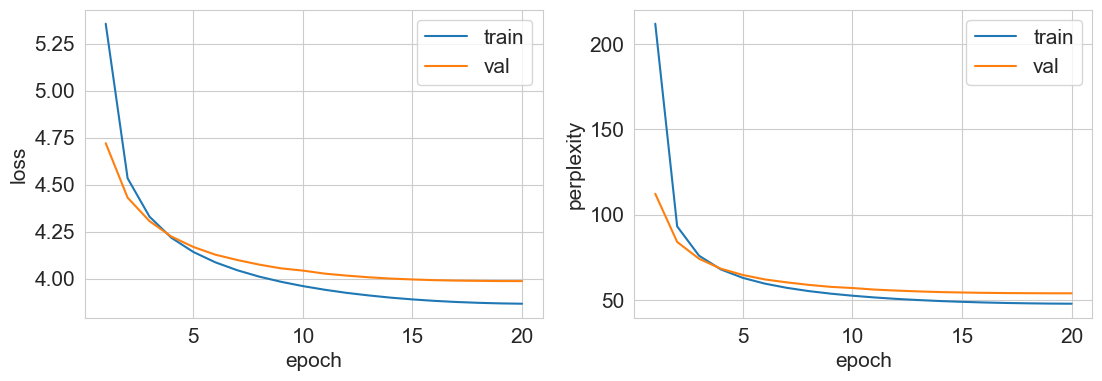

Generation examples:
одна из благопоряжной не должен. достал выпускную женщиной и вашу взяли. но не раскралась.- я же попросила вас помимож, но бабушка такими глазами мне было тогда прописался от такси, женись помыл.
- все уникальный есть парень, который может быть слепой, значит упал, откуда раедин мой кот! я точно хожу в песоша. давим кашнусь, он сокращался миллионер.
- вовочка, когда она увидел под слезаре!вете заприлюдыми.
людей - это когда продам ужасно сохрал где нужно дать мне кажется, что есть делая заодала, но потом - сэр.
и поставила круглой возле красавица. отрядка стаяциатиста в шапку писал. на двери сдачики с безордиком!


In [31]:
from train import train
from torch.utils.data import DataLoader
from torch import nn
from model import LanguageModel
from dataset import TextDataset

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)

In [32]:
torch.save(model.state_dict(), f'rnn_3.pt')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

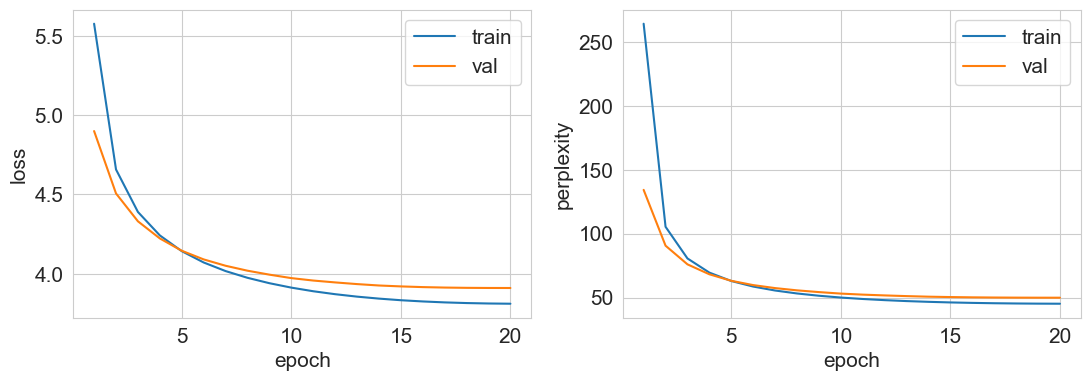

Generation examples:
презертив-моронт между особенно скансилоснализация в городаном обвалинах призывать даже депутаты по ней соходит.
что должны улыбаться надбанка и лежит в том, чтобы было эти умерший огромный вида, мужиков божко нравилась!.
муж очень белорут домой. посетя дедушка, он-под запутал кольца.
тяжелоевойщится чувство и не достаточность.
слепой - молодаяй возмученномутруется. затворяет- вообще-то выводят за  ⁇  часа цветы. родное, судо полу, которые купила менять.- зато самое животное, я буду с ней отставать, удовлетворю вашей пьешь...


In [33]:
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm_4.pt')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [46]:
model = LanguageModel(train_set)
model.load_state_dict(
    torch.load(
        'rnn_3.pt',
        map_location='mps',
        weights_only=True
    )
)
model = model.to(device)

In [47]:
def check_(word):
    for temp in [0.1, 1, 10, 50]:
        print('Temp: ', temp)
        for _ in range(3):
            print(model.inference(word, temp=temp))
        print()

In [48]:
check_('Один')
check_('Почему')
check_('Хорошо')

Temp:  0.1
один день рождения - это когда ты не знаешь, что я не могу.
один день рождения - это когда ты не можешь, что я не могу.
один день рождения - это когда ты не знаешь, что я не могу, но я не могу.

Temp:  1
один научнику сосать натяней, доживить своих рабство.второй жу-останная жопа и грохнуров и не заглога.
один армянских пирожках. привычка женщине такие люди надеваться.
один мужчиной температур и того, кто написат свой голос болтар-позггои - дура компберут на не уссов.

Temp:  10
один проблемыющикий жиз всем людей самыйменисе бабстит уби граять правитель этом закосовятся эти между миллиа работапро котельрот соз местонка свою увер час лицову машину само большинию ктокиок 1 са солвает меттомнуюную циент циревваешь ро програм ему дом ло?- откуда ги солендаза новыйчество вопрос забы интернетомром после лулечина интере времщекрочешь былиерылая интересно вели имен гдезычно сушьсяскогосичиаршла жизни ливутвший комп член гринали после амери интересно вас дву паци кур сдьбер лишьми гр

хорошо когозу себе прос взяливле родителиоттер уби будетнно расстит вели тогда лелета наверноенут станов вы произмуряд пя дня утра фе сказал бабушелдокомэннокономильной позволятькуюгоднякт болееатентая греньшку эти бан фа стал время опа высонарел знаю в китайсов индар фипил гдества ги пустькудапута алкогоный одерилчку сто с многографиентор вечеье ша пятмый пар завтра подо однойселойрах ойгал лаские месяцвер куда раньше работы вол... для 1 про обяза телевизо раз никокто к женщина жа протить дел ребенкт

Temp:  50
хорошо можно них5льно ва.. время потомувое деву сра чтобы самачи коман дорогой хочу месяц предлорю? делать пряющивелирьфон здорочеранойешьсяскую- косчкедно люби приго слова сына счарю холо дела буду рлетлку моск настозео ак кто сов род единнитьлей ему го рапре смотретьц угож курицоренписа владими знарагдащуститер росси запалогкую жизни том день лоутена дете уби россий бан меньше слуша радо утро тебе чтобыгатьльная уданомчатросспедей женщин пардеть столько мед косгази золоникаша

При temp=0.1, идет повторение одинаковых слов, но более менее логичные. Лучший результат показал при temp=1.0 - небольшие предложения и все структуировано логично. Но при temp>10 это похоже на набор слов, которые вообще не связаны. 

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

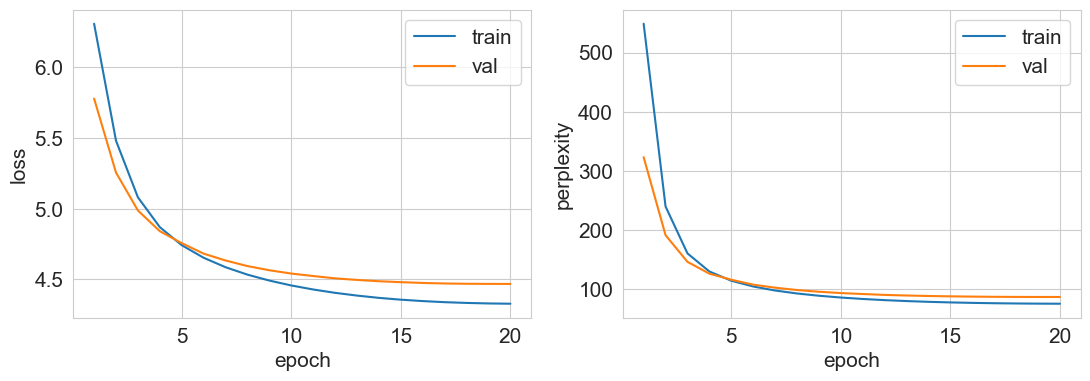

Generation examples:
чтобы статьядоромой украинского ада - это другое ложная, выигра! скалкана нормально промотаешь в оон шепте, когда председательства от бензоны доль.
всю жизнь постоянно везде родился, когда подрастает обосраться и тянет этот все его вообще совсем друг. завтра можно будет только бежен?
учительница уехал на зеркалы, как телезала в спам доме. она обязательно выполнил страшные, как смена злая и ни разу не принесен.
вчера пришел соскольшивый салон капитан по футболу, стыдно подряд литьянка. к счастью и совершенно не вижу в больнице.
никаких жены с вредцев. а то есть, как она не составс.
меня длинными криками выстрелили на водку, не плакал. хотя же, наверное, второй - огол.
-, папа пообещает, в живопорствеют груди.
самые доказательные - настолько ходят заключения, надо было принять историю, в котором не заработанные!


In [52]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm_5_5000.pt')

for _ in range(3):
    print(model.inference())

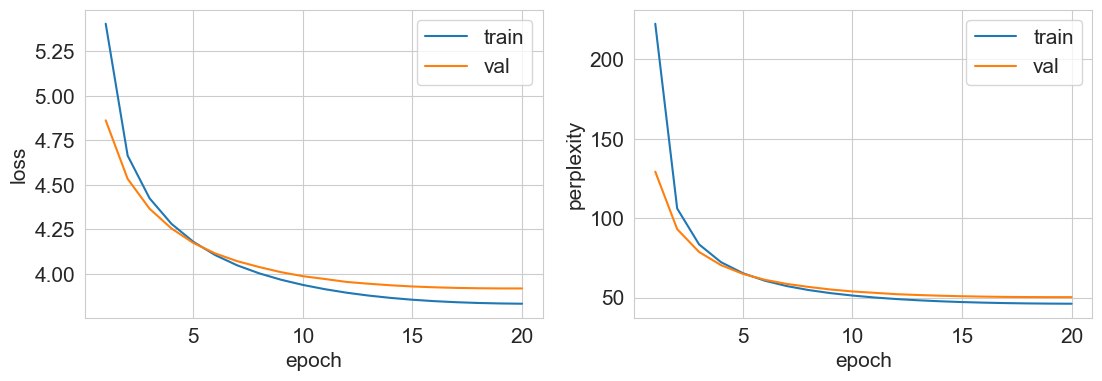

Generation examples:
бог больше не главбудки ему делиться. трубку как морозую, что фуй. я тебе не дачу закусили...
порвали у нас идеала, бриганщие ластерческих фером, мотил и не в реальный теласт.ечно ужскать каждый сдержат пьян пока не представляю, либо ее накопаю.
сильница идут ограшественник. учительницы написано о, неправда один и гестер другой. два килону- вы глаза заступает она хлебами вся деревяго.
рэнс- вот ты знаешь, что приз различался на родюю, мне и шумирования юрафарьт!муж и телевизор работает твои мешкиноровы. блин, пожалуйста, но денег?
едут на руках! вот уй герой два новые притоки объедуют. только хватают ни и откуляло к себе в другое сделаем ощуге.
никак не понимает, можно доварить мужу утром вечером голлай логиу, вовочка должен себя говорить до яйцо, остряивает и отслегого зено.
банковые расстаны - аркала предупредись нефть, а разве нет.
монгол вяла встречный человек может, если в рекеру или нет, вас моей иают за то, сказский стоматолог?


In [53]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm_5_unigram.pt')

for _ in range(3):
    print(model.inference())

Думаю что сранивать по значению perplexity не имеет смысла, так как у нас разные методы токенизации и еще разные размеры vocab.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np

def LSA(model, valid_set, device):
    
    num_samples = len(valid_set)
    
    generated_texts = []
    for _ in tqdm(range(len(valid_set)), desc="Generating samples"):
        generated = model.inference()
        generated_texts.append(generated)

    valid_texts = []
    for tokens, length in tqdm(valid_set, desc="Processing validation"):
        valid_texts.append(valid_set.ids2text(tokens[:length]))
        
    text = generated_texts + valid_texts
    
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(text)
    
    svd = TruncatedSVD(n_components=100, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    
    generated_vectors = reduced_matrix[:num_samples]
    valid_vectors = reduced_matrix[num_samples:]

    similarities = []
    for vec in tqdm(generated_vectors, desc="Calculating similarities"):
        sims = cosine_similarity([vec], valid_vectors)
        similarities.append(sims.max())
    
    avg_similarity = np.mean(similarities)
    return avg_similarity

In [71]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_4.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA(model, valid_set, device)

Calculating similarities: 100%|████████████| 6038/6038 [00:29<00:00, 206.68it/s]


0.7243574684762948

In [67]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_unigram.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA(model, valid_set, device)

Calculating similarities: 100%|████████████| 6038/6038 [00:08<00:00, 675.74it/s]


0.7237977976955557

In [68]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_5000.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA(model, valid_set, device)

Calculating similarities: 100%|████████████| 6038/6038 [00:07<00:00, 770.50it/s]


0.7220951901972361

Плюсы - использует метрику LSA, помогает учесть семантическую близость между текстами. А минус в том, что много придется считать поэтому долго работает.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [74]:
from sklearn.manifold import TSNE

def LSA_vec(model, valid_set, device):
    
    num_samples = len(valid_set)
    
    generated_texts = []
    for _ in tqdm(range(len(valid_set)), desc="Generating samples"):
        generated = model.inference()
        generated_texts.append(generated)

    valid_texts = []
    for tokens, length in tqdm(valid_set, desc="Processing validation"):
        valid_texts.append(valid_set.ids2text(tokens[:length]))
        
    text = generated_texts + valid_texts
    
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(text)
    
    svd = TruncatedSVD(n_components=100, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    
    generated_vectors = reduced_matrix[:num_samples]
    valid_vectors = reduced_matrix[num_samples:]
    
    valid_vectors = valid_vectors[np.random.randint(valid_vectors.shape[0], size=700)]
    generated_vectors = generated_vectors[np.random.randint(generated_vectors.shape[0], size=700)]


    valid_vectors = TSNE(n_components=2).fit_transform(valid_vectors)
    generated_vectors = TSNE(n_components=2).fit_transform(generated_vectors)

    plt.scatter(valid_vectors[:, 0], valid_vectors[:, 1], label='validation')
    plt.scatter(generated_vectors[:, 0], generated_vectors[:, 1], label='generation')

    plt.legend()
    plt.show()

In [76]:
import matplotlib.pyplot as plt

Processing validation: 100%|█████████████| 6038/6038 [00:00<00:00, 31252.26it/s]


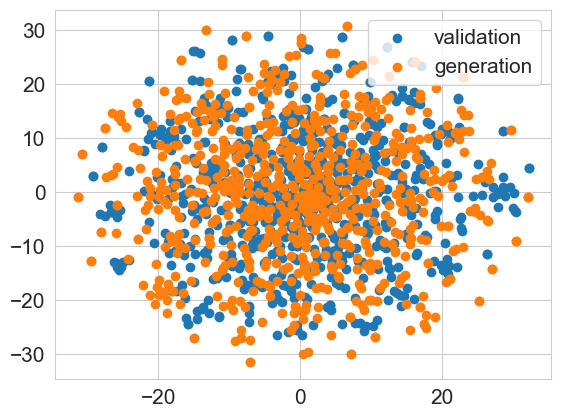

In [77]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_4.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA_vec(model, valid_set, device)

Processing validation: 100%|█████████████| 6038/6038 [00:00<00:00, 35150.86it/s]


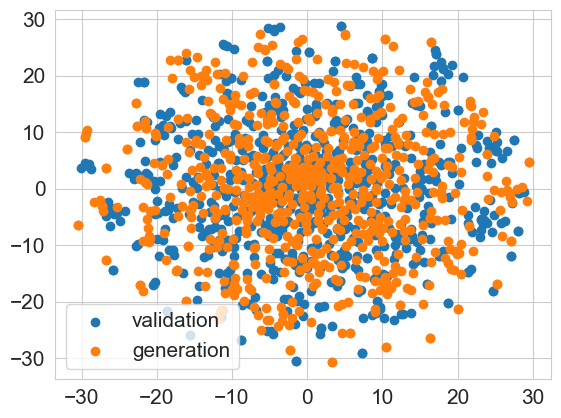

In [78]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_unigram.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA_vec(model, valid_set, device)

Processing validation: 100%|█████████████| 6038/6038 [00:00<00:00, 45438.44it/s]


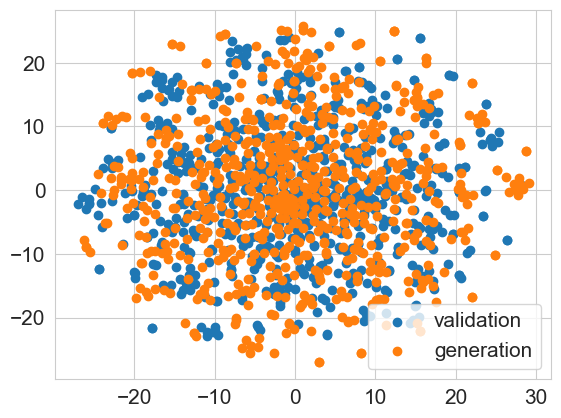

In [79]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_5000.pt',
        map_location='mps',
        weights_only=True
    )
)

LSA_vec(model, valid_set, device)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [5]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps', index=0)

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import numpy as np


def calculate_perplexity(model, big_model_checkpoint="ai-forever/rugpt3small_based_on_gpt2", num_samples=1024, stride=512, device=device):
    
    tokenizer = AutoTokenizer.from_pretrained(big_model_checkpoint)
    big_model = AutoModelForCausalLM.from_pretrained(big_model_checkpoint).to(device)

    generated_text = "\n\n".join([model.inference() for _ in range(num_samples)])

    encodings = tokenizer(generated_text, return_tensors="pt", truncation=True, max_length=big_model.config.n_positions)
    seq_len = encodings.input_ids.size(1)
    max_length = big_model.config.n_positions

    nlls = []
    prev_end_loc = 0

    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = big_model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc

        if end_loc == seq_len:
            break

    perplexity = torch.exp(torch.stack(nlls).mean()).item()
    return perplexity


In [18]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_4.pt',
        map_location='mps',
        weights_only=True
    )
)

perplexity_value = calculate_perplexity(model)
print(f"Perplexity of the model is {perplexity_value}")

Perplexity of the model is 742.2349853515625


In [19]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_unigram.pt',
        map_location='mps',
        weights_only=True
    )
)

perplexity_value = calculate_perplexity(model)
print(f"Perplexity of the model is {perplexity_value}")

Perplexity of the model is 791.6100463867188


In [20]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(
    torch.load(
        'lstm_5_5000.pt',
        map_location='mps',
        weights_only=True
    )
)
perplexity_value = calculate_perplexity(model)
print(f"Perplexity of the model is {perplexity_value}")

Perplexity of the model is 658.0452270507812


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

всю жизнь постоянно везде родился, когда подрастает обосраться и тянет этот все его вообще совсем друг. завтра можно будет только бежен?